# Co-Clustering Representatives and Bills of the 119th U.S. House

## Introduction

### 1. Overview
In this notebook, we apply the **Hypergraph Co-Clustering** model (implemented in this repository) to analyze voting behavior in the **119th U.S. House of Representatives**.

Our goal is to infer latent structure in the voting data in an unsupervised manner, without using party labels or bill metadata during training:
* **Representatives:** Do they form voting blocs that deviate from strict party lines?
* **Bills:** Can we cluster bills based on who votes for them, rather than just their content?
* **Polarization:** How much heterogeneity exists within the Democratic and Republican parties?

---

### 2. Data Source
House Roll Call data is sourced from **Voteview**, specifically:
* **$X$ (Roll Call Matrix):** A binary matrix of size $M$ (Bills) $\times$ $N$ (Representatives).
    * $1 =$ "Yea"
    * $0 =$ "Nay"
    * `NaN` = Abstention/Absence 

This is a hypergraph where each Bill is a hyperedge (event), and each Representative is a node.

* **Metadata:** (not used in training)
    * **Politicians:** Party affiliation, state, and identifiers.
    * **Bills:** Topic codes, descriptions, and sponsor information.

---

### 3. Methodology

Hypergraph model:
* Each representative is a node
* Each bill is a hyperedge, i.e. a collection of nodes.

Assumptions:
* Every Representative belongs to a latent group $k$
* Every Bill belongs to a latent group $g$. 
* The probability of a ‘Yea’ vote is a function of the interaction between these two groups ($\theta_{kg}$).

We cluster the representatives and bills simultaneously, using a custom Variational Expectation-Maximization algorithm.

### Workflow
- **Data ingestion & preprocessing:** Download roll-call votes, encode Yea/Nay, filter high-abstention reps.  
- **Exploration:** Inspect the voting matrix and abstention distributions.  
- **Modeling:** Fit Hypergraph Co-Clustering with Variational EM and select $(K,G)$ via ICL.  
- **Validation & interpretation:** Check ELBO, assignment confidence, and relate clusters to party labels, bill outcomes, and DW-NOMINATE scores.  
- **Visualization:** Reorder matrix to reveal block structure.

In [1]:
CONFIG = {
    'CONGRESS': 119, # The Congress number to analyze
    'CHAMBER': 'House', # 'House' or 'Senate'
    "CUTOFF_DATE": "2026-01-01",   # Cutoff date for bills. Used for consistensy, as the 119th congress is ongoing.    
    'OUTLIER_QUANTILE': 0.97,  # Quantile threshold for filtering abstainers. Larger is stricter. Range [0,1]
    'N_NODE_CLUSTER_RANGE': range(1, 11), # Range of clusters for Representatives
    'N_HYPEREDGE_CLUSTER_RANGE': range(1, 11), # Range of clusters for Bills
    'SEED_K2': 5, 
    'SEED_K4': 4,
    'MODEL_SELECTION_SEED': 42            
}

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV
from hypervem.visualizations import (
    visualize_parameters, 
    plot_model_selection_heatmap, 
    plot_hypergraph, 
    plot_sorted_hypergraph, 
    visualize_parameters_matrix
)
from hypervem.utils import find_ambiguous_elements
from hypervem.model import HypergraphCoClustering


## Part A: Data Loading and Cleaning

We define the data scope:
* **Congress:** 119th (Ongoing)
* **Chamber:** House of Representatives only
* **Geography:** U.S. States only (excluding territories like Puerto Rico/Guam due to limited voting rights)

The code below downloads the latest Roll Call data and creates two "metadata" dataframes to map matrix indices back to real-world entities (Representatives and Bills).

In [3]:
def create_bill_lookup_table(congress_number=CONFIG['CONGRESS'], chamber=CONFIG['CHAMBER'], cutoff_date=CONFIG['CUTOFF_DATE']):
    """
    Creates a metadata table for the bills (hyperedges).
    """
    # Bill metadata for this congress
    url = f"https://voteview.com/static/data/out/rollcalls/H{congress_number}_rollcalls.csv"
    
    try:
        bills_df = pd.read_csv(url)
    except:
        # Fallback: If specific congress file doesn't exist, load all and filter
        url = "https://voteview.com/static/data/out/rollcalls/HSall_rollcalls.csv"
        print(f"Loading all rollcalls from {url} and filtering...")
        all_bills = pd.read_csv(url)
        bills_df = all_bills[all_bills['congress'] == congress_number].copy()

    # Filter by chamber
    mask = (bills_df['chamber'].str.contains(chamber, case=False))
    df = bills_df[mask].copy()

    # Only keep bills until a certain date
    # This is to ensure reproducibility of the analysis,
    # as new bills keep coming in. 
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    cutoff = pd.Timestamp(cutoff_date)
    df = df[df['date'] < cutoff]

    # Extract metadata for bills
    lookup = pd.DataFrame({
        'rollnumber': df['rollnumber'],  
        'bill_number': df['bill_number'], 
        'date': pd.to_datetime(df['date']),
        'description': df['vote_desc'],  
        'result': df['vote_result'],      
        'question': df['vote_question']
    }).sort_values('rollnumber')

    # Link each hyperedge in X with a Bill in lookup
    lookup['hyperedge_index'] = range(len(lookup))
    return lookup.set_index('rollnumber', drop=False)

def create_politician_lookup_table(congress_number=CONFIG['CONGRESS'], chamber=CONFIG['CHAMBER']):
    """
    Creates a metadata table for the representatives (nodes)
    """
    # Link for the representative metadata 
    url = "https://voteview.com/static/data/out/members/HSall_members.csv"
    members_df = pd.read_csv(url)

    # List of territories with limited voting rights
    territories = ['DC', 'PR', 'VI', 'GU', 'AS', 'MP']

    # Filter based on chamber and congress number
    # Remove territories with limited voting rights
    mask = (members_df['congress'] == congress_number) & \
       ((members_df['chamber'].str.contains(chamber, case=False)) |
        (members_df['chamber'].str.contains('President', case=False))) & \
        ~(members_df['state_abbrev'].isin(territories))
    df = members_df[mask].copy()
    
    # Extract metadata
    lookup = pd.DataFrame({
        'Name': df['bioname'],
        'ICPSR_ID': df['icpsr'],
        'Party': df['party_code'].map({100:'Democrat', 200:'Republican'}).fillna('Other'),
        'State': df['state_abbrev'],
        'nominatedim': df['nominate_dim1']
    }).sort_values('ICPSR_ID')
    
    # Link each representative with a node in X
    lookup['node_index'] = range(len(lookup))
    
    # Set ICPSR_ID as index for lookups, but keep the columns clean
    return lookup.set_index('ICPSR_ID', drop=False)

def load_congress_data_with_both_lookups(congress_number=CONFIG['CONGRESS']):
    # Roll Call dataset

    url = f"https://voteview.com/static/data/out/votes/H{congress_number}_votes.csv"
    df = pd.read_csv(url)
    # Binary mapping (Yea=1, Nay=0, Abstain=NaN)
    df['binary_vote'] = df['cast_code'].map({1:1, 2:1, 3:1, 4:0, 5:0, 6:0})
    df = df.dropna(subset=['binary_vote'])
    
  
    matrix_df = df.pivot(index='icpsr', columns='rollnumber', values='binary_vote')
    
    # Create lookup tables
    politician_lookup = create_politician_lookup_table(congress_number, chamber=CONFIG['CHAMBER'])
    bill_lookup = create_bill_lookup_table(congress_number, chamber=CONFIG['CHAMBER'])

    # The matrix might be missing some politicians (who never voted) 
    # or some bills (that had no recorded votes).
    # We remove them as they contain no information.
    
    # Intersect Indices (Politicians)
    valid_politicians = matrix_df.index.intersection(politician_lookup.index)
    matrix_df = matrix_df.loc[valid_politicians]
    ordered_politician_lookup = politician_lookup.loc[valid_politicians]
    
    # Intersect Columns (Bills)
    valid_bills = matrix_df.columns.intersection(bill_lookup.index)
    matrix_df = matrix_df[valid_bills]
    ordered_bill_lookup = bill_lookup.loc[valid_bills]

    X = matrix_df
    
    # Reset node_index on lookup tables to match the FINAL matrix dimensions
    ordered_politician_lookup['node_index'] = range(len(ordered_politician_lookup))
    ordered_bill_lookup['hyperedge_index'] = range(len(ordered_bill_lookup))
    
    return X.T, ordered_politician_lookup, ordered_bill_lookup

In [4]:
X, politician_lookup, bill_lookup = load_congress_data_with_both_lookups(congress_number=CONFIG['CONGRESS'])

We inspect the incidence matrix (`X`) and the metadata/lookup datasets (`politician_lookup` , `bill_lookup`)

In [5]:
print(f"{X.shape[0]} bills (rows) and {X.shape[1]} representatives (columns)")
X.head()


361 bills (rows) and 439 representatives (columns)


,14854,14863,14873,15029,15433,15448,15454,15616,20107,20119,...,29776,29901,29908,29910,29911,31101,31102,39301,39307,91980
rollnumber,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,...,0.0,0.0,NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,0.0,NaN,...,1.0,1.0,NaN,0.0,1.0,1.0,0.0,1.0,1.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,...,0.0,0.0,NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0
5,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [6]:
politician_lookup.head()

,Name,ICPSR_ID,Party,State,nominatedim,node_index
14854,"ROGERS, Harold Dallas (Hal)",14854,Republican,KY,0.334,0
14863,"SMITH, Christopher Henry",14863,Republican,NJ,0.183,1
14873,"HOYER, Steny Hamilton",14873,Democrat,MD,-0.381,2
15029,"KAPTUR, Marcia Carolyn (Marcy)",15029,Democrat,OH,-0.342,3
15433,"MFUME, Kweisi",15433,Democrat,MD,-0.441,4


In [7]:
bill_lookup.head()

,rollnumber,bill_number,date,description,result,question,hyperedge_index
rollnumber,,,,,,,
1,1,NaN,2025-01-03,NaN,Johnson (LA),Election of the Speaker,0
2,2,HRES5,2025-01-03,Adopting the Rules of the House of Representat...,Passed,On Ordering the Previous Question,1
3,3,HRES5,2025-01-03,Adopting the Rules of the House of Representat...,Failed,On Motion to Commit with Instructions,2
4,4,HRES5,2025-01-03,Adopting the Rules of the House of Representat...,Passed,On Agreeing to the Resolution,3
5,5,HR29,2025-01-07,Laken Riley Act,Passed,On Passage,4


### Handling Missing Metadata
Occasionally, bills are reintroduced or modified, leading to gaps in the `description` field. The following block checks for bills with missing descriptions and imputes them using the first available description for the same Bill Number.

In [8]:
# Group by bill_number and count unique, non-null descriptions
unique_desc_counts = bill_lookup.groupby('bill_number')['description'].nunique()

# Filter for bills that have 2 or more different descriptions
conflicting_bills = unique_desc_counts[unique_desc_counts > 1]

print(f"Total Bill Numbers: {len(unique_desc_counts)}")
print(f"Bills with conflicting descriptions: {len(conflicting_bills)}")

# If there are conflicts, print them
for j in range(len(conflicting_bills)):
    print("\n--- Conflicts ---")
    example_id = conflicting_bills.index[j]
    subset = bill_lookup[bill_lookup['bill_number'] == example_id]
    print(f"Bill Number: {example_id}")
    print(subset[['rollnumber', 'description']].to_string(index=False))

# Fill NaNs with the valid description from the same bill_number
bill_lookup['description'] = bill_lookup.groupby('bill_number')['description'].transform('first')

Total Bill Numbers: 231
Bills with conflicting descriptions: 1

--- Conflicts ---
Bill Number: HR1
 rollnumber                description
        143      One Big Beautiful Act
        144      One Big Beautiful Act
        189 One Big Beautiful Bill Act


## Part B: Analysis and Model Fitting

### 1. Visual Inspection of the Raw Data
First, we visualize the raw voting matrix $X$.
* **Rows:** Bills (Hyperedges)
* **Columns:** Representatives (Nodes)
* **Color:** Orange = Yes, Blue = No, White = NA (Abstain)

> **Visual Guide:**
> * **Vertical Streaks:** Individual politicians. A solid white vertical line indicates a representative who rarely votes.
> * **Horizontal Streaks:** Individual bills. A solid color horizontal band indicates a unanimous vote.

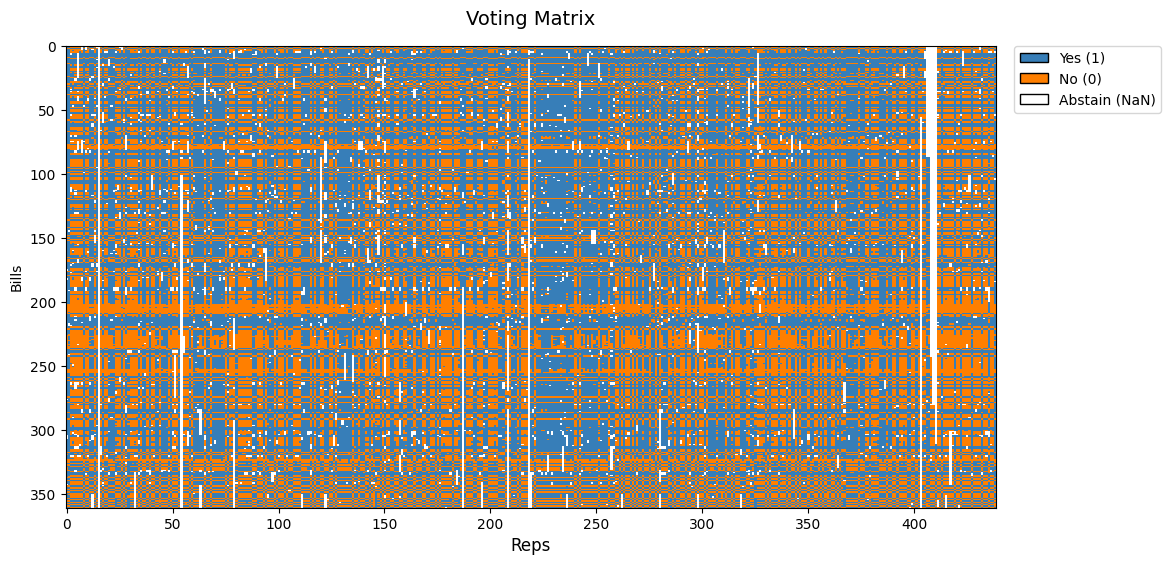

In [9]:
X_large_dirty = X.to_numpy()

plot_hypergraph(X_large_dirty,
                xlabel = "Reps",
                ylabel = "Bills",
                title = "Voting Matrix",
                yes_label = "Yes (1)",
                no_label = "No (0)",
                nan_label = "Abstain (NaN)",
                show_ticks=True)
plt.show()

### 2. Filtering Low-Information Representatives
Representatives with excessive abstentions (missing votes) introduce noise into the clustering algorithm. If a column is mostly `NaN`, the model struggles to assign that representative to a group, leading to higher uncertainty within the groups.

We calculate the abstentions of each representative, and plot the histogram.

In [10]:
abstention_counts = (X.isna()).sum(axis=0)  
 
total_votes = X.shape[0] 

abstention_rate = abstention_counts / total_votes
politician_lookup['Abstention_Rate'] = abstention_rate

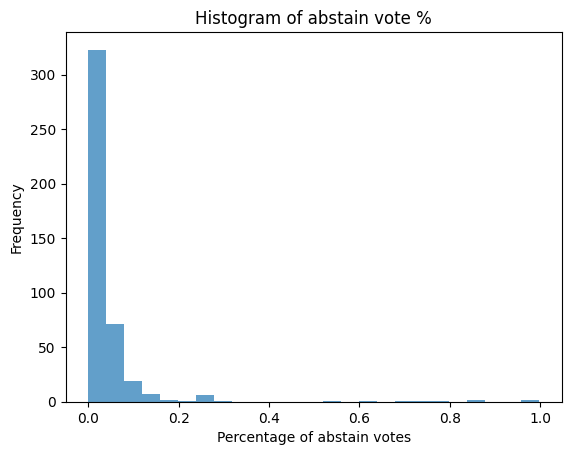

In [11]:
abstains = politician_lookup["Abstention_Rate"]
plt.hist(abstains,
         bins=25,
         alpha=0.7
         )
plt.title("Histogram of abstain vote %")
plt.xlabel("Percentage of abstain votes")
plt.ylabel("Frequency")
plt.show()

The distribution of abstain votes is heavily skewed, with the majority of representatives missing close to 0% of the votes.

**Outlier detection:**

Instead of setting an arbitrary cutoff %, we will perform outlier detection using quantiles. 
This way, we can check which representatives systematically vote differently (in terms of abstain frequency) than their colleagues. 

Approach:
1.  Identify the **97th percentile** of abstention rates as a threshold.
2.  Remove the top 3% of abstainers from the dataset.

In [12]:
threshold = np.quantile(abstains, 0.97)  # top 3% as outliers
outlier_rows = np.where(abstains > threshold)[0]

X_large = np.delete(X_large_dirty, outlier_rows, axis=1)
politician_lookup = politician_lookup[~politician_lookup['node_index'].isin(outlier_rows)]

print(f"Threshold = {threshold*100:.2f}%")
print(f"Number of outlier representatives removed: {len(outlier_rows)}")

Threshold = 24.38%
Number of outlier representatives removed: 12


We visually inspect the new hypergraph.

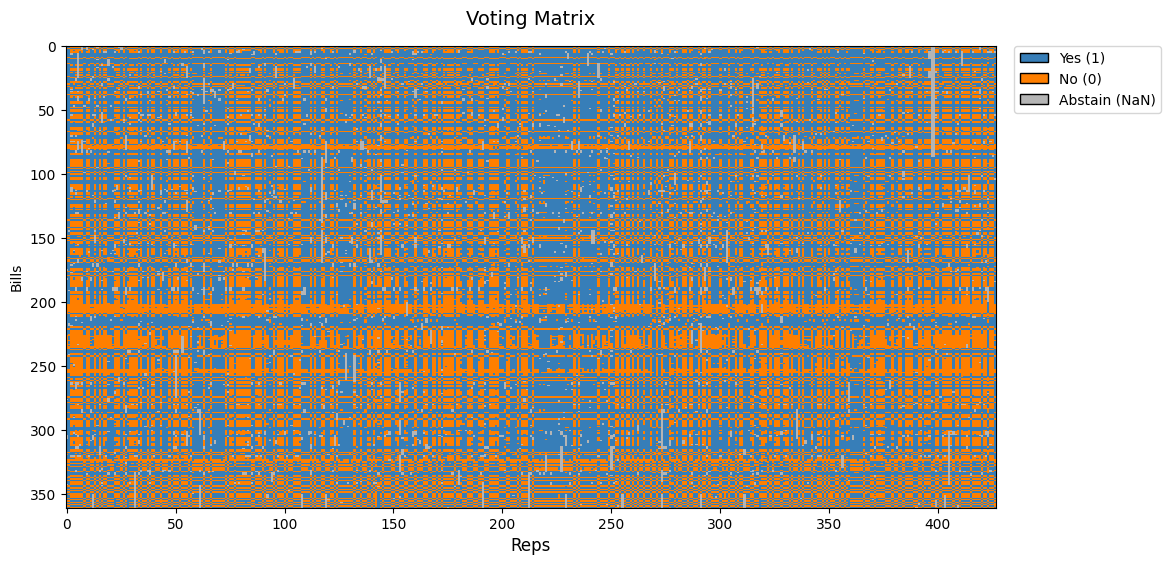

In [13]:
plot_hypergraph(X_large,
                xlabel = "Reps",
                ylabel = "Bills",
                title = "Voting Matrix",
                yes_label = "Yes (1)",
                no_label = "No (0)",
                nan_label = "Abstain (NaN)",
                show_ticks=True,
                nan_color="#B5B5B5")
plt.show()

By removing the outliers, we ensure that every column in our matrix contains sufficient signal ("Yea"/"Nay" votes) for the VEM algorithm to learn distinct voting patterns.

### 3. Model Selection: Choosing `n_node_clusters` ($K$) and `n_hyperedge_clusters` ($G$)

We need to choose the number of latent groups for Representatives ($K$ / `n_node_clusters`) and Bills ($G$ / `n_hyperedge_clusters`). To do this, we perform a grid search over $K, G \in [1, 10]$.

**Evaluation Metric: ICL**  

We use the **Integrated Completed Likelihood (ICL)**, which balances model fit and complexity. 

A higher ICL indicates a better fit, but increasing $K$ and $G$ also increases complexity. 

To select an interpretable yet informative model, we select the point where further increases in $K$ or $G$ yield diminishing improvements in ICL.

*Note: We use `GridSearchCV` solely for its parallelized parameter grid search. As our `score` is an information criterion, we do not perform any cross-validation, and therefore our train/test sets both consist of the entire dataset, i.e. 1-fold CV.*


In [14]:
# The Variational EM algorithm is transductive: cluster assignments are inferred jointly
# for all observations, and no out-of-sample prediction is defined.
# Since model selection is performed using the Integrated Completed Likelihood (ICL),
# which must be evaluated on the full dataset, we intentionally disable data splitting.
# The train and test sets therefore coincide with the complete dataset.
indices = np.arange(X_large.shape[0])
cv_no_split = [(indices, indices)] 

# Grid Search using GridSearchCV
print("\n--- Grid Search ---")
grid = GridSearchCV(
    estimator=HypergraphCoClustering(n_init=3, random_state=CONFIG['MODEL_SELECTION_SEED']),
    param_grid={'n_node_clusters': CONFIG['N_NODE_CLUSTER_RANGE'], 'n_hyperedge_clusters': CONFIG['N_HYPEREDGE_CLUSTER_RANGE']},
    cv=cv_no_split,
    verbose=1,
    n_jobs=-1  
)

grid.fit(X_large)


--- Grid Search ---
Fitting 1 folds for each of 100 candidates, totalling 100 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",HypergraphCoC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'n_hyperedge_clusters': range(1, 11), 'n_node_clusters': range(1, 11)}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.","[(array([ 0, ...58, 359, 360]), ...)]"
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is 

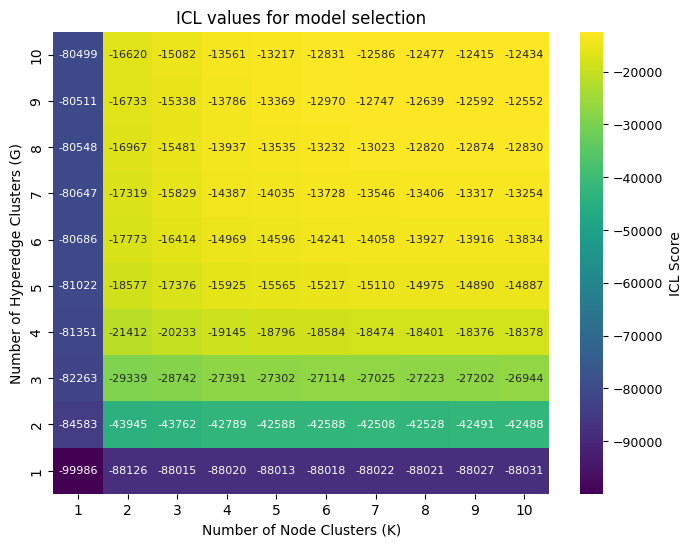

In [15]:
plot_model_selection_heatmap(grid.cv_results_)
plt.show()

### 4.1 Fitting `n_node_clusters`$= 2$, `n_hyperedge_clusters`$= 4$
**Observations from the Grid Search:**
* **Representatives (`n_node_clusters`):** Increasing `n_node_clusters` from 1 to 2 provides a massive gain in information. However, adding a 3rd group yields negligible improvement. This suggests the House is mainly divided into **two primary voting blocs**.
* **Bills (`n_hyperedge_clusters`):** The ICL increases steadily up to 4 hyperedge groups before leveling off. This indicates there are **four main types of legislation** in the 119th Congress.

We proceed with two models, one where **`n_node_clusters`** $=2$, and another where **`n_hyperedge_clusters`** $=4$.

We fit and visualize this model.

**Left/Right Boxes**: Display the population proportions for Representative (node) and Bill (hyperedge) groups, respectively.

**Connections**: Weighted edges show the probability of node-hyperedge membership (e.g., Group 1 Nodes have a 99% probability of joining Group 1 Hyperedges).

Run 1/5 [K=2, G=4]: ICL=-21385.35, Iter=14
Run 2/5 [K=2, G=4]: ICL=-21412.36, Iter=7
Run 3/5 [K=2, G=4]: ICL=-26329.15, Iter=18
Run 4/5 [K=2, G=4]: ICL=-26329.15, Iter=18
Run 5/5 [K=2, G=4]: ICL=-21385.35, Iter=14
Best run restored (ICL=-21385.35).


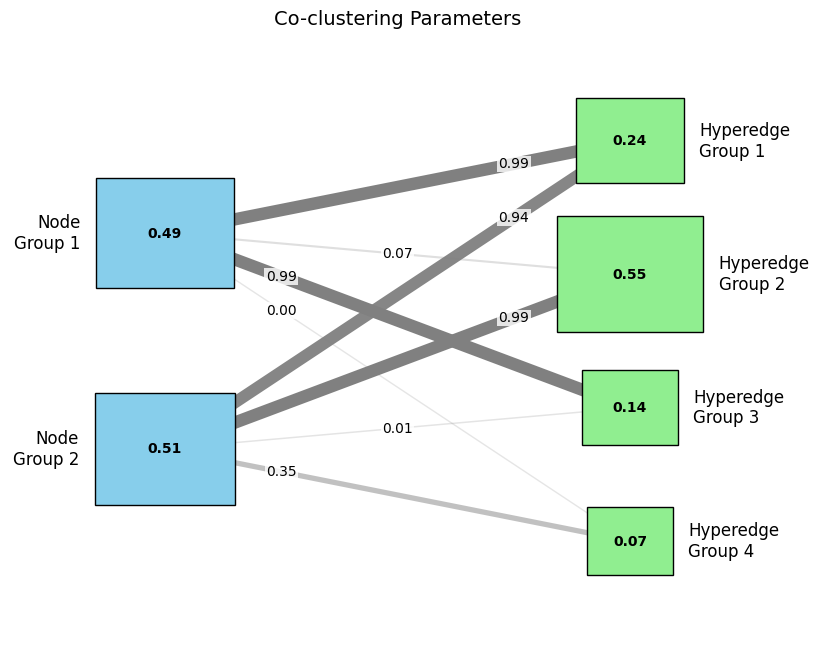

In [16]:
seed_k2 = CONFIG['SEED_K2']

s_model = HypergraphCoClustering(
    n_node_clusters=2, 
    n_hyperedge_clusters=4, 
    verbose=True, 
    init_method="random", 
    n_init=5, 
    convergence_criterion="elbo",
    random_state=seed_k2
)
s_model.fit(X_large)

visualize_parameters(s_model.gamma_, s_model.delta_, s_model.theta_, display_connectivity=True)
plt.show()

We identify two representative (node) groups of similar size:
- **Representative Group 1:** 49% of representatives
- **Representative Group 2:** 51% of representatives

The model also infers four bill (hyperedge) groups:
- **Bill Group 1 (24%)**: Bipartisan bills (99% / 94% “Yes”)
- **Bill Group 2 (55%)**: Supported almost exclusively by **Rep. Group 2**
- **Bill Group 3 (14%)**: Supported almost exclusively by **Rep. Group 1**
- **Bill Group 4 (7%)**: Controversial bills (≈35% “Yes” from **Rep. Group 2**, ≈0% from **Rep. Group 1**)

####  4.1.1 **Interpreting the Latent Groups**

i. **Representative Clusters** (`n_node_clusters` = 2)

We relate the inferred representative clusters with the ground truth party labels to interpret the latent voting structure.

Specifically, we ask:
1. What voting blocs are identified by the model?
2. Do representatives within the same party exhibit different voting patterns?

In [17]:
politician_lookup['Cluster'] = s_model.node_clusters_ + 1

distribution_counts = pd.crosstab(
    politician_lookup['Cluster'], 
    politician_lookup['Party']
)

print("--- Distribution of Parties per Cluster (Counts) ---")
print(distribution_counts)

distribution_pct = pd.crosstab(
    politician_lookup['Cluster'], 
    politician_lookup['Party'], 
    normalize='index'
) * 100

print("\n--- Distribution of Parties per Cluster (Percentage) ---")
print(distribution_pct.round(2).sort_index(level = "Democrat"))

--- Distribution of Parties per Cluster (Counts) ---
Party    Democrat  Republican
Cluster                      
1             209           0
2               0         218

--- Distribution of Parties per Cluster (Percentage) ---
Party    Democrat  Republican
Cluster                      
1           100.0         0.0
2             0.0       100.0


We see that the inferred clusters align perfectly with the party of a representative. 

Therefore:
1. The identified voting blocs align with party affiliation, meaning the main driver of voting behavior is the representative's party.
2. With a parsimonious choice of `n_node_clusters` $=2$, we find no evidence of strong within-party deviations in voting behavior.

ii. **Bill Clusters** (`n_hyperedge_clusters` $= 4$)

We characterize the four bill clusters using:
1. **Passage Rate:** How frequently do bills in the cluster pass?
2. **Consensus:** What is the average “Yea” rate?
3. **Procedure:** What is the most common legislative question (e.g. “On Passage”, “Motion to Recommit”)?

In [18]:
bill_lookup['cluster'] = s_model.hyperedge_clusters_ + 1
bill_lookup['yea_rate'] = X.mean(axis=1).round(2)


def get_pass_pct(series):
    passed = series.astype(str).str.contains('Passed|Agreed to', case=False, regex=True)
    return (passed.mean() * 100).round(1)

profile = bill_lookup.groupby('cluster').agg({
    'yea_rate': 'mean',                  # Avg support (individual votes)
    'result': [
        lambda x: x.mode()[0],           # Most common result text
        get_pass_pct                     # % of bills that actually passed
    ],
    'question': lambda x: x.mode()[0],   # Most common vote type
    'rollnumber': 'count'                # Total bills
})

profile.columns = ['Avg_Yea_Rate', 'Most_Common_Result', 'Pass_Rate_%', 'Most_Common_Question', 'Count']
print(profile)

         Avg_Yea_Rate Most_Common_Result  Pass_Rate_%  \
cluster                                                 
1            0.967093             Passed        100.0   
2            0.538250             Passed         94.5   
3            0.496471             Failed         11.8   
4            0.178750             Failed          0.0   

                            Most_Common_Question  Count  
cluster                                                  
1        On Motion to Suspend the Rules and Pass     86  
2                                     On Passage    200  
3                          On Motion to Recommit     51  
4                   On Agreeing to the Amendment     24  


Combining all the information, we conclude that the bills got clustered into the following four groups:

* **Group 1 - Bipartisan Consensus:** Routine bills (e.g., naming schools). **Passage: 100%.**
* **Group 2 - Minority Agenda:** Procedural motions (e.g., "Motion to Recommit"), supported by minority-aligned reps. **Low passage.**
* **Group 3 - Majority Agenda:** Majority-driven legislation. Mostly supported by majority-aligned reps. **High passage**
* **Group 4 - Bipartisan Disapproval:** Controversial bills. Minimal support even from majority. **Passage: 0%**


**The grouped matrix plot**

We permute the rows and columns of the original incidence matrix $X$ so that representatives and bills belonging to the same cluster are grouped together.

By reordering the matrix, we transform the initial noise into a clear block structure, where

- Representatives within the same block vote with similar patterns
- Bills within the same block receive votes from the same representative groups

This reordered matrix visually supports the block structure assumed by the model.

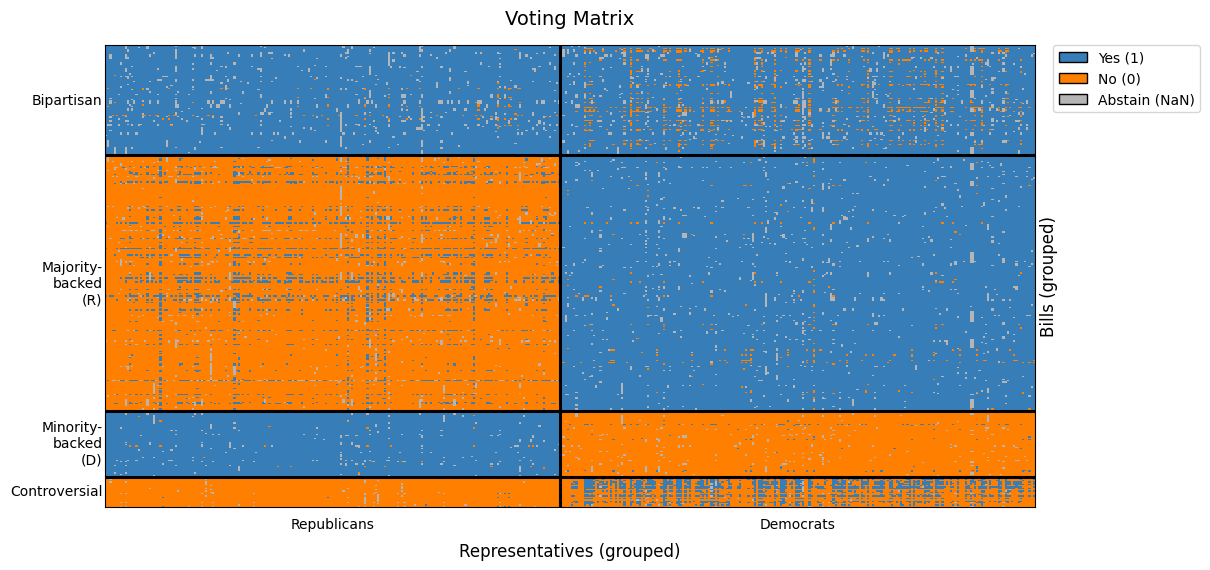

In [19]:
ax = plot_sorted_hypergraph(X_large,
                            row_labels=s_model.hyperedge_clusters_,
                            col_labels=s_model.node_clusters_,
                            xlabel = "Representatives (grouped)",
                            ylabel = "Bills (grouped)",
                            title = "Voting Matrix",
                            yes_label = "Yes (1)",
                            no_label = "No (0)",
                            nan_label = "Abstain (NaN)",
                            nan_color= "#B5B5B5",
                            custom_group_cols={0:"Republicans", 1:"Democrats"},
                            custom_group_rows= {0:"Bipartisan", 1:"Majority-\nbacked\n(R)", 2: "Minority-\nbacked\n(D)", 3: "Controversial"})

plt.show()

#### 4.1.2 **Post-hoc checks**

We perform two post-hoc checks, to confirm that our model was fit properly and that there were no numerical stability issues.

1. **ELBO plot**: 

The Evidence Lower Bound (ELBO) is theoretically guaranteed to increase (or stay constant) between two consecutive VEM iterations. Therefore, if we plot its evolution over iterations, we must see an increasing curve. If the ELBO decreases at any point, there were numerical stability issues.

2. **Ambiguous Representatives/ Bills**: 

The VEM is a probabilistic estimator. It assigns a probability of belonging to a cluster. These probabilities are aliased `node_responsibilities_` and `hyperedge_responsibilities_` respectively. We check for "ambiguous" elements, i.e. representatives or bills that the model was unsure about (Probability < 95%).

##### i. ELBO plot

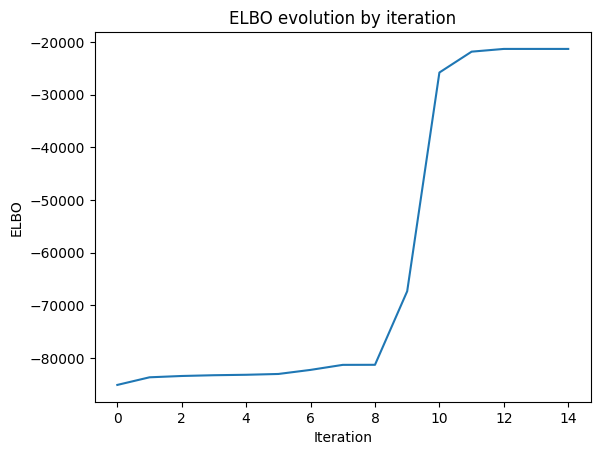

In [20]:
plt.plot(s_model.elbo_history_)
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.title("ELBO evolution by iteration")
plt.show()

##### ii. Confidence Check

In [21]:
# We set a threshold of 95%
# The function returns any node or hyperedge with a probability < 95% of belonging to its cluster
bad_nodes = find_ambiguous_elements(s_model.node_responsibilities_, threshold=0.95)
bad_hyperedges = find_ambiguous_elements(s_model.hyperedge_responsibilities_, threshold=0.95)

print(f"Found {len(bad_nodes)} ambiguous nodes.")
print(bad_nodes.head())

print(f"Found {len(bad_hyperedges)} ambiguous hyperedges.")
print(bad_hyperedges.head())

Found 0 ambiguous nodes.
Empty DataFrame
Columns: [Index, Confidence]
Index: []
Found 0 ambiguous hyperedges.
Empty DataFrame
Columns: [Index, Confidence]
Index: []


The ELBO plot shows an increasing function over iterations, and our model has confidently classified every representative and bill into a cluster with over 95% probability. Therefore, the model has been fit well.

### **4.2 Fitting `n_node_clusters` $=4$, `n_hyperedge_clusters` $=4$**

Although we identified `n_node_clusters` $=2$ as the most parsimonious model, we can increase it to explore finer sub-groups within the data.

The ICL continues to improve marginally at higher `n_node_clusters`, suggesting that valid sub-groups exist. 

By setting `n_node_clusters` $=4$, we force the algorithm to partition the broad party coalitions into smaller blocks. 

This allows us to investigate **within-party heterogeneity**, i.e. whether distinct voting factions (e.g., "Moderates" vs. "Mainstream") exist within each party.

We fit an extended model with `n_node_clusters` $=4$ (Representatives) and `n_hyperedge_clusters` $= 4$ (Bills).

In [22]:
seed_k4 = CONFIG['SEED_K4']

extended_model = HypergraphCoClustering(
    n_node_clusters=4, 
    n_hyperedge_clusters=4, 
    verbose=True, 
    init_method="random", 
    n_init=5, 
    convergence_criterion="elbo",
    random_state=seed_k4
)

extended_model.fit(X_large)

politician_lookup['Cluster'] = extended_model.node_clusters_ + 1

distribution_counts = pd.crosstab(
    politician_lookup['Cluster'], 
    politician_lookup['Party']
)

print("--- Distribution of Parties per Cluster (Counts) ---")
print(distribution_counts)

distribution_pct = pd.crosstab(
    politician_lookup['Cluster'] , 
    politician_lookup['Party'], 
    normalize='index'
) * 100

print("\n--- Distribution of Parties per Cluster (Percentage) ---")
print(distribution_pct.round(2).sort_index(level = "Democrat"))

Run 1/5 [K=4, G=4]: ICL=-24551.35, Iter=29
Run 2/5 [K=4, G=4]: ICL=-23991.24, Iter=22
Run 3/5 [K=4, G=4]: ICL=-19145.12, Iter=24
Run 4/5 [K=4, G=4]: ICL=-34531.30, Iter=20
Run 5/5 [K=4, G=4]: ICL=-20126.30, Iter=30
Best run restored (ICL=-19145.12).
--- Distribution of Parties per Cluster (Counts) ---
Party    Democrat  Republican
Cluster                      
1             149           0
2              60           0
3               0         149
4               0          69

--- Distribution of Parties per Cluster (Percentage) ---
Party    Democrat  Republican
Cluster                      
1           100.0         0.0
2           100.0         0.0
3             0.0       100.0
4             0.0       100.0


We visualize the inferred parameters as a matrix, as the bipartite graph representation can get messy with many groups.

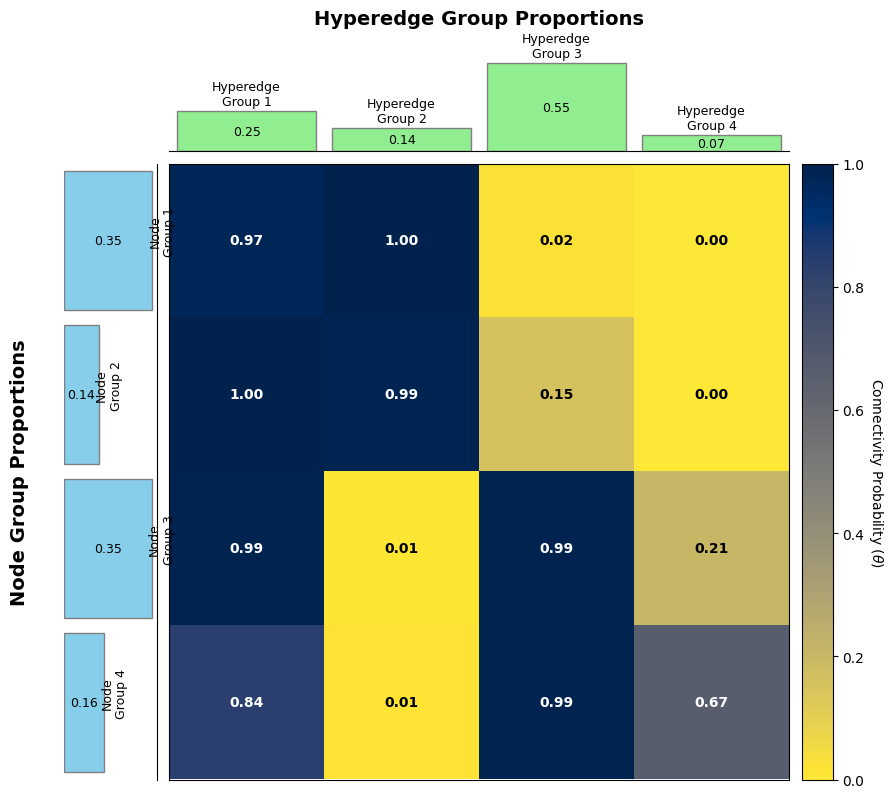

In [23]:
visualize_parameters_matrix(extended_model.gamma_, extended_model.delta_, extended_model.theta_, cmap="cividis_r")
plt.show()

####  4.2.1 **Interpreting the Latent Groups**
We repeat the process of connecting the inferred groups to the extra data from the lookup tables.

In [24]:
bill_lookup['cluster'] = extended_model.hyperedge_clusters_ + 1
bill_lookup['yea_rate'] = X.mean(axis=1).round(2)


def get_pass_pct(series):
    passed = series.astype(str).str.contains('Passed|Agreed to', case=False, regex=True)
    return (passed.mean() * 100).round(1)

profile = bill_lookup.groupby('cluster').agg({
    'yea_rate': 'mean',                  # Avg support (individual votes)
    'result': [
        lambda x: x.mode()[0],           # Most common result text
        get_pass_pct                     # % of bills that actually passed
    ],
    'question': lambda x: x.mode()[0],   # Most common vote type
    'rollnumber': 'count'                # Total bills
})

profile.columns = ['Avg_Yea_Rate', 'Most_Common_Result', 'Pass_Rate_%', 'Most_Common_Question', 'Count']
print(profile)

         Avg_Yea_Rate Most_Common_Result  Pass_Rate_%  \
cluster                                                 
1            0.961348             Passed        100.0   
2            0.496471             Failed         11.8   
3            0.534315             Passed         94.4   
4            0.178750             Failed          0.0   

                            Most_Common_Question  Count  
cluster                                                  
1        On Motion to Suspend the Rules and Pass     89  
2                          On Motion to Recommit     51  
3                                     On Passage    197  
4                   On Agreeing to the Amendment     24  


In [25]:
politician_lookup['Cluster'] = extended_model.node_clusters_ + 1

distribution_counts = pd.crosstab(
    politician_lookup['Cluster'], 
    politician_lookup['Party']
)

print("--- Distribution of Parties per Cluster (Counts) ---")
print(distribution_counts)

distribution_pct = pd.crosstab(
    politician_lookup['Cluster'] , 
    politician_lookup['Party'], 
    normalize='index'
) * 100

print("\n--- Distribution of Parties per Cluster (Percentage) ---")
print(distribution_pct.round(2).sort_index(level = "Democrat"))

--- Distribution of Parties per Cluster (Counts) ---
Party    Democrat  Republican
Cluster                      
1             149           0
2              60           0
3               0         149
4               0          69

--- Distribution of Parties per Cluster (Percentage) ---
Party    Democrat  Republican
Cluster                      
1           100.0         0.0
2           100.0         0.0
3             0.0       100.0
4             0.0       100.0


**Interpretations:**

**Bill groups:** 

Unchanged from the `n_node_clusters` $=2$ case. The labels have been permuted (e.g. The Bipartisan group is now "Group 2" instead of "Group 1"), but the clusters have remained identical.

**Representative groups:**
The `n_node_clusters` $=4$ model introduced two new clusters, which split the former 2 clusters into a total of 4 entities:

- **Cluster 1 - Democratic mainstream:** Strongly partisan, closely matching the earlier Democrat block.
- **Cluster 2 - Moderate Democrats:** Mostly align with Democratic voting, but occasionally support Republican-backed bills.
- **Cluster 3 - Republican mainstream:** Strongly partisan, closely matching the earlier Republican block.
- **Cluster 4 - Atypical Republicans:** Less supportive of bipartisan bills and more likely to back controversial legislation.

**DW_NOMINATE comparison**

To strengthen our categorization of these clusters, we examine the distribution of DW-NOMINATE (`nominatedim`) scores. This metric, developed by Voteview, places representatives on a continuous ideological scale ranging from −1 to 1, where lower values indicate more liberal (Democratic-aligned) beliefs and higher values indicate more conservative (Republican-aligned) beliefs.

* -1: Extremely Democrat
* 0: Centrist
* +1: Extremely Republican


This metric was not used during training, and is only used for a post-hoc analysis.

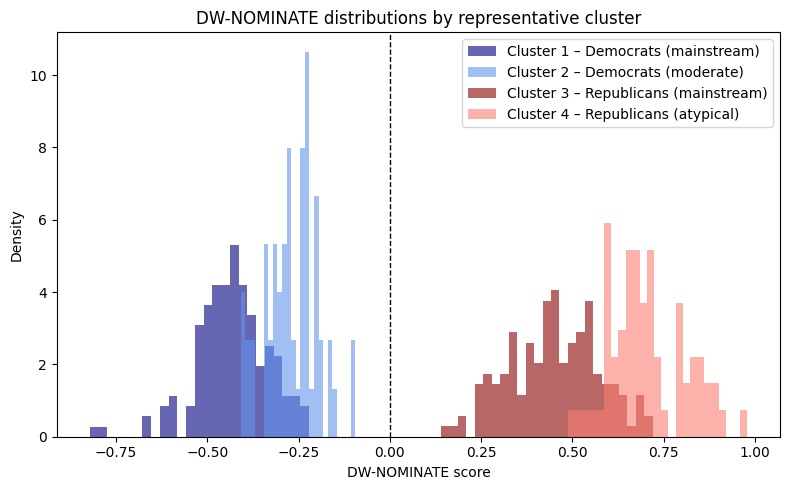

In [26]:
cluster_specs = {
    1: {
        "label": "Cluster 1 – Democrats (mainstream)",
        "color": "navy",            
    },
    2: {
        "label": "Cluster 2 – Democrats (moderate)",
        "color": "cornflowerblue",           
    },
    3: {
        "label": "Cluster 3 – Republicans (mainstream)",
        "color": "darkred",              
    },
    4: {
        "label": "Cluster 4 – Republicans (atypical) ",
        "color": "salmon",    
    },

}

plt.figure(figsize=(8, 5))

for k, spec in cluster_specs.items():
    values = politician_lookup.loc[politician_lookup["Cluster"] == k, "nominatedim"]

    plt.hist(
        values,
        bins=25,
        density=True,
        alpha=0.6,
        label=spec["label"],
        color=spec["color"],
    )

plt.axvline(0, linestyle="--", linewidth=1, color = "black")
plt.xlabel("DW-NOMINATE score")
plt.ylabel("Density")
plt.title("DW-NOMINATE distributions by representative cluster")
plt.legend()
plt.tight_layout()
plt.show()

This further supports our earlier interpretation of the two new clusters. 

The new Democrat cluster captures more moderate representatives, which are more center-leaning than their mainstream counterparts, whereas the new Republican cluster captures representatives grounded in conservatism, compared to their mainstream counterparts. 

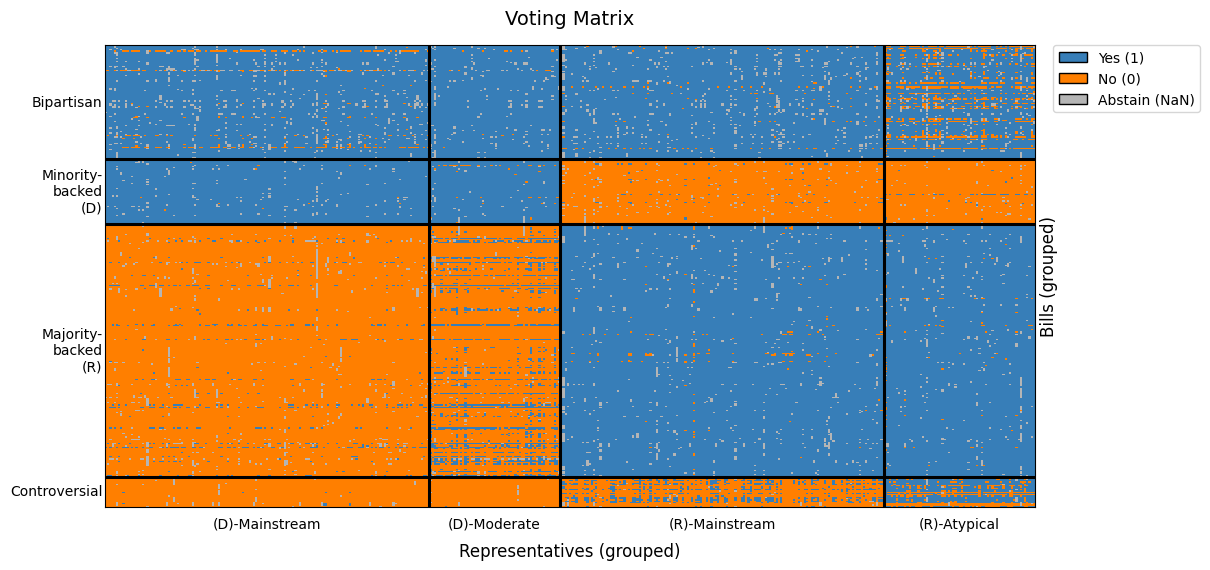

In [27]:
ax = plot_sorted_hypergraph(X_large,
                            row_labels=extended_model.hyperedge_clusters_,
                            col_labels=extended_model.node_clusters_,
                            xlabel = "Representatives (grouped)",
                            ylabel = "Bills (grouped)",
                            title = "Voting Matrix",
                            yes_label = "Yes (1)",
                            no_label = "No (0)",
                            nan_label = "Abstain (NaN)",
                            nan_color= "#B5B5B5",
                            show_group_labels = True,
                            custom_group_rows={0: "Bipartisan", 2: "Majority-\nbacked\n(R)", 1:"Minority-\nbacked\n(D)", 3:"Controversial"},
                            custom_group_cols={0: "(D)-Mainstream", 2: "(R)-Mainstream", 3:"(R)-Atypical", 1:"(D)-Moderate"})


plt.show()

#### 4.2.2 Post Hoc tests

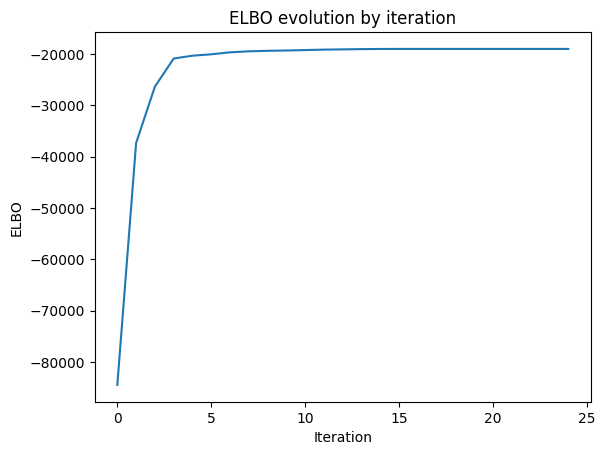

In [28]:
plt.plot(extended_model.elbo_history_)
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.title("ELBO evolution by iteration")
plt.show()

In [29]:
bad_nodes = find_ambiguous_elements(extended_model.node_responsibilities_, threshold=0.95)
bad_hyperedges = find_ambiguous_elements(extended_model.hyperedge_responsibilities_, threshold=0.95)

print(f"Found {len(bad_nodes)} ambiguous nodes.")
print(bad_nodes.head())

print(f"Found {len(bad_hyperedges)} ambiguous hyperedges.")
print(bad_hyperedges.head())

Found 17 ambiguous nodes.
    Index  Confidence
4     182    0.536387
5     191    0.550271
9     238    0.579829
15    392    0.581171
1      57    0.595763
Found 0 ambiguous hyperedges.
Empty DataFrame
Columns: [Index, Confidence]
Index: []


The ELBO is strictly increasing, confirming that there were no numerical stability issues. However, forcing this split resulted in 17 low-confidence nodes. It seems that increasing `n_node_clusters` (or `n_hyperedge_clusters`, though not applicable here) leads to a higher number of ambiguous nodes (or hyperedges).

The reason for this behavior is twofold:
1. Increasing the number of groups reduces the effective sample size per group, leading to less accurate inference.
2. When a block with a "strong signal" (as seen with `n_node_clusters` $=2$) is forced to split, the resulting subgroups can exhibit weaker signals. This can cause the noise to signal ratio to increase for certain nodes.

## Part C: Conclusion

### 1. Summary of Findings

This notebook demonstrated the application of a Hypergraph Co-Clustering model to roll-call voting data from the 119th U.S. House of Representatives. The model recovered node clusters that align closely with party labels, and hyperedge clusters which describe the way the Bills within the House operate. This was done without feeding any extra data to the model, but rather purely from the voting matrix. 

Insights:

* **Party affiliation is the primary driver of voting behavior** (`n_node_clusters` $=2$): The model's most parsimonious fit identified two distinct blocs that align perfectly with the Democratic and Republican parties. This suggests that voting behavior in the 119th Congress is primarily driven by party affiliation.
* **Within-party heterogeneity** (`n_node_clusters` $=4$): When configured for higher resolution, the model detected sub-structures *within* the major parties, effectively distinguishing **"Mainstream"** loyalists from **"Moderate/Atypical"** legislators.
* **The Structure of Legislation**: The model automatically categorized Bills into interpretable types, separating bipartisan consensus legislation from controversial, partisan-driven agenda items.


### 2. Methodological Validation
The stability of the Variational Expectation-Maximization (VEM) algorithm was confirmed through:
* **ELBO Convergence**: The Evidence Lower Bound showed a strictly increasing trend, indicating numerical stability of our Variational EM implementation.
* **High Confidence**: Even in the `n_node_clusters` $=4$ scenario, the vast majority of representatives were assigned to clusters with $>95\%$ probability.

### 3. Limitations and further directions
While this analysis focused on a static snapshot of the 119th Congress, the Hypergraph Co-Clustering framework suggests several routes for future work:
* Developing a temporal version of the model to track how representatives migrate between clusters over time.
* Extending the binary Bernoulli framework to a categorical distribution to explicitly model "Abstain" votes, capturing "silent disagreements" rather than treating them as missing data.
* Applying the model to multi-party systems (e.g. European parliaments) where coalitions are common, and polarization is weaker.